# Evaluation

The goal of this evaluation is to show how Disciplined Inconsistency allows applications to achieve stronger consistency while still meeting their performance bounds. Those parts of the application marked as tolerant of inconsistency provide a safety valve, allowing the application to remain available under adverse conditions, such as high load, network partitions, or clients with poor connectivity.

In [18]:
source('plot/common.r', chdir=T)
display <- function(p) embed_notebook(p)
out <- function(obj) write(obj, stdout())
options(repr.plot.width=6.5, repr.plot.height=4.5, jupyter.plot_mimetypes='image/svg+xml')

## Rawmix microbenchmark

This microbenchmark, modeled after YCSB, performs simple random operations to a `Set` data structure that supports IPA bounds.

### Performance in adverse conditions

In [38]:
d <- data.ipa.rawmix(where="ipa_duration = 60 and ipa_version = 'v1.3'")
out(nrow(d))

sub <- function(d) subset(d, !is.na(condition) & grepl('normal|slowpoke_flat', honeycomb_mode))
out("subset: "+nrow(sub(d)))

163
subset: 140


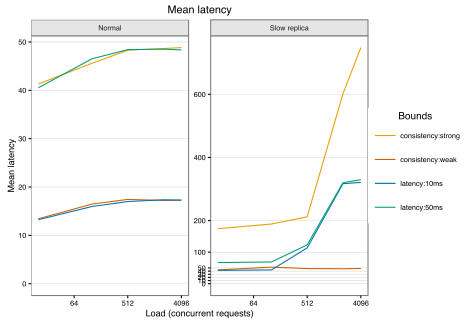

In [33]:
d$grp <- d$ipa_bound
ggplot(sub(d), load <= 4096), aes(
    x = load,
    y = timers_contains_latency_mean,
    color=grp, fill=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Mean latency')+
    xlab('Load (concurrent requests)')+
    ylab('Mean latency')+
    scale_x_continuous(trans=log2_trans())+
    scale_y_continuous(breaks=c(0,10,20,30,40,50,100,200,400,600))+
    ipa.scales()+
    expand_limits(x = 0, y = 0)+
    facet_wrap(~condition, scales="free")+
    my_theme()

Under 'normal' conditions, all replicas have a 10ms latency. Under those conditions, weakly consistent reads average around 10-20ms latencies, while strong ends up at 40-50ms. Our tight 10ms latency bound must always use weak consistency to come close to meeting its target. However, the looser 50ms bound can wait for strong consistency and still meet its target, under these favorable conditions.

However, when one replica is particularly slow (in this case, 100ms latency), we see that achieving strong consistency now takes significantly longer, around 200ms. In this case, our 50ms latency bound is achievable only by accepting weak consistency. However, this means that clients still get the nearly the same performance as if they had used weak consistency all along.

Ideally, the latency-bound curves would track the weakly consistent one at high load. However, because our implementation currently issues strong and weak in parallel, at high load the Cassandra servers get overloaded and we see some degradation in performance as a result. *This can be addressed with dynamic monitoring, which I aim to implement.*

*Aside:* Around 512 clients, we see something saturating. I believe it is that we're hitting a point where coordinating the strongly consistent ops is saturating the CPUs on the client or server side. Tried running both with 1 client node & 3 server nodes and 2 client nodes and 1 server node — seems like we're most likely bottlenecked on the client right now, since it goes up a bit with more client cores, but then it's bottlenecked on the server. Another theory is that it's simply serializing (not quite sure how Cassandra parallelizes, but it's reasonable to believe that it's mostly using its other threads for handling messages, leaving one to do the majority of the dirty work).

One thing I aim to do which should impact this curve: I want to do simple dynamic tracking and determine when we should just give up on strong consistency (e.g. monitor recent latencies of strong ops, if it's much greater than our bound then don't even try). If this works, it should help the IPA curves match the weak one at high load (which is ideal).

If we think this matters (in terms of absolute performance, or showing scalability), perhaps we can do some separate experiments to investigate differences in scalability but do the bulk of the experiments with < 512 clients.

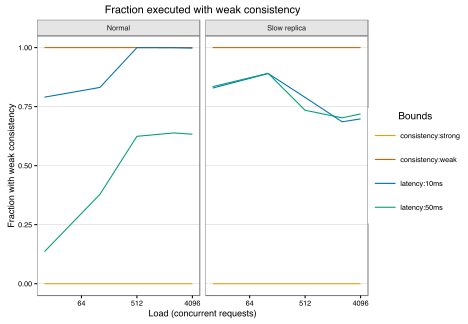

In [56]:
d$weak_count <- d$counters_contains_weak_count
d$strong_count <- d$counters_contains_strong_count
d$fraction_weak <- with(d, weak_count / (weak_count + strong_count))

ggplot(subset(sub(d), load <=4096), aes(x = load, y = fraction_weak, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_wrap(~condition)+
    ggtitle('Fraction executed with weak consistency')+
    xlab('Load (concurrent requests)')+
    ylab('Fraction with weak consistency')+
    ipa.scales()+
    my_theme()

In this plot, we see the fraction of operations that were completed with weak consistency. As we can see, under normal conditions, the 50ms latency bound achieves strong consistency quite often, but has to resort to weaker consistency more as the load increases. The tighter 10ms bound must resorts to weak consistency most of the time.

*I'm not sure why the two IPA curves for 'slow replica' aren't at or near 100% weak. Investigating this now.*

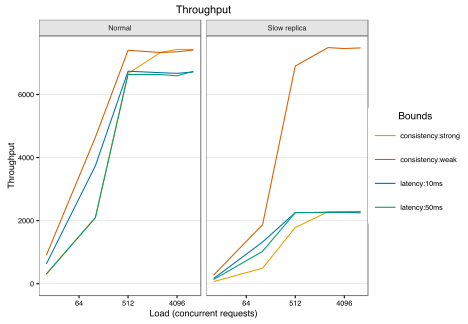

In [31]:
d$grp <- d$ipa_bound
ggplot(sub(d), aes(
    x = load,
    y = timers_contains_latency_mean_rate,
    color=grp, fill=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Throughput')+
    xlab('Load (concurrent requests)')+
    ylab('Throughput')+
    scale_x_continuous(trans=log2_trans())+
    ipa.scales()+
    expand_limits(x = 0, y = 0)+
    facet_wrap(~condition)+
    my_theme()

This plot confirms that we're peaking around 512 clients on one node and after that, latencies should be expected to shoot up and behave erratically. If we care to scale higher, we'll need to run multiple clients in parallel, but I'm not convinced it's super interesting.